# DIAGRAM GENERATION

This notebook serves as first test of the synthesis algorithm. Small circuits are generated and saved to files. The
files are then read and converted into matrices.

Those matrices are then fed into the synthesis algorithm which synthesises an output circuit. The resulting output
circuit is expected to be shorter than the input circuit.

For both the input and the output circuit a diagram is generated.

If a non-singular matrix would be used as input directly, there would be no possibility to know the number of gates of
the input circuit.

### IMPORTS

Perform the imports and check how many threads are available.

In [9]:
from multiprocessing import Pool, cpu_count
import numpy as np
from src.input.write_files import write_circuit_file
from src.input.read_files import find_files, numbers_from_file_name, number_from_text, normal_sec_size_int_from_file_name, file_to_circuit
from src.diagrams.tikz import circuit_to_tikz_file
from IPython.display import SVG, display
import os
from src.input.circuits_and_matrices import circuit_to_matrix
from src.algorithm.circuit_synthesis_vanilla import synthesise_circuit
from src.algorithm.execution import check_and_run

print(f'There are {cpu_count()} threads available on this machine.')

There are 12 threads available on this machine.


### PARAMETERS

Define the parameters in order to generate input circuits of certain size and length and specify where to save the
relevant files.

Due to the section size being

$m = \frac{1}{2} log_2(n)$

and the restriction that $m \geq 2$, the smallest circuit size $n$ that can be used is $n=8$.

In [10]:
size_num_gates_pairs = np.array([(8, 6), (8, 30)])

input_gen_processors = 1

input_dir = r'resources\circuit_diagrams\input_circuits'

circuit_file_prefix = 'Circuit'

diagram_dir = r'resources\circuit_diagrams'

### INPUT GENERATION

The arguments for the input generation are predefined as a list of tuples. The generation itself is executed on a thread
pool.

In [11]:
input_gen_argument_tuples = ([(size, num_gates, rf'..\{input_dir}\{circuit_file_prefix}_{size}_{num_gates}.txt') for (size, num_gates) in size_num_gates_pairs])

[print(argument_tuple) for argument_tuple in input_gen_argument_tuples[:min(10, len(input_gen_argument_tuples))]]

(8, 6, '..\\resources\\circuit_diagrams\\input_circuits\\Circuit_8_6.txt')
(8, 30, '..\\resources\\circuit_diagrams\\input_circuits\\Circuit_8_30.txt')


[None, None]

In [4]:
print(f'Generating {len(input_gen_argument_tuples)} circuits ...')

if __name__ ==  '__main__':
    with Pool(processes = input_gen_processors) as pool:
        pool.starmap(write_circuit_file, input_gen_argument_tuples)

print(f'Saved circuits to {input_dir} ...')

Generating 2 circuits ...
Saved circuits to resources\circuit_diagrams\input_circuits ...


### DIAGRAM GENERATION

Once the circuits are read, they can be converted to a SVG file. The helper function below makes a call to the Linux
Subsystem for Windows (WSL) in order to convert a temporary TikZ file to an SVG image. A more thorough explanation can
be found in *src.diagrams.README.md*.

In [12]:
def circuit_to_svg(circuit, size, diagram_dir, file_prefix):

    num_gates = len(circuit)

    file_name = rf'{file_prefix}_{size}_{num_gates}'

    tikz_file_path = rf'..\{diagram_dir}\{file_name}.tikz'

    circuit_to_tikz_file(circuit, size, tikz_file_path)

    wsl_tikz_path = rf'\mnt\c\Dev\cnot_synthesis\{diagram_dir}\{file_name}.tikz'.replace('\\','/')

    command_string = rf'wsl tikztosvg -p tikz-cd -p xfrac {wsl_tikz_path} > /dev/null 2>&1'
    os.system(command_string)

    os.remove(rf'..\{diagram_dir}\{file_name}.tikz')

    return file_name + '.svg'

### READ FILES

The generated files are searched for using a regex. In order to run them a list of argument tuples is created again.

In [13]:
file_regex = rf'({circuit_file_prefix}).*\.txt'
size_regex = r'_\d+_'
num_gates_regex = r'_\d+\.'

input_file_names = find_files(rf'..\{input_dir}', file_regex)
input_file_names.sort(key = lambda input_file_name: numbers_from_file_name(input_file_name, size_regex, num_gates_regex))

run_argument_tuples = [(number_from_text(input_file_name, size_regex),
                        normal_sec_size_int_from_file_name(input_file_name, size_regex),
                        rf'..\{input_dir}\{input_file_name}')
                       for input_file_name in input_file_names]

[print(tuple) for tuple in run_argument_tuples[:min(10, len(run_argument_tuples))]]

(8, 2, '..\\resources\\circuit_diagrams\\input_circuits\\Circuit_8_6.txt')
(8, 2, '..\\resources\\circuit_diagrams\\input_circuits\\Circuit_8_30.txt')


[None, None]

### DIAGRAM OF INPUT CIRCUIT

input circuit length: 30


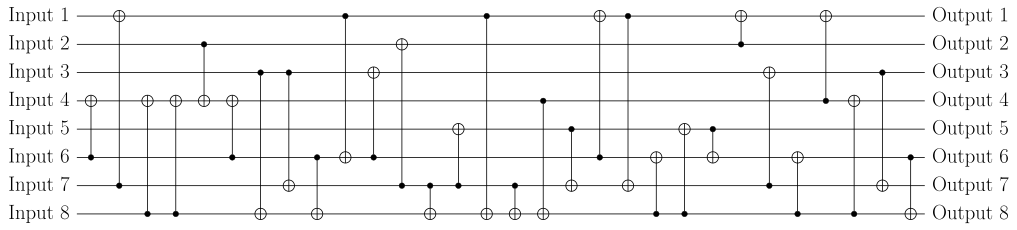

In [14]:
(size, sec_size, input_file_path) = run_argument_tuples[1]

input_circuit = file_to_circuit(input_file_path)

input_diagram_file_name = circuit_to_svg(input_circuit, size, diagram_dir, circuit_file_prefix + '_in')

print(f'input circuit length: {len(input_circuit)}')
SVG(rf'..\{diagram_dir}\{input_diagram_file_name}')

### DIAGRAM OF OUTPUT CIRCUIT

The input circuit is converted into a matrix and an output circuit is synthesised. The output circuit is then displayed.

output circuit length: 28


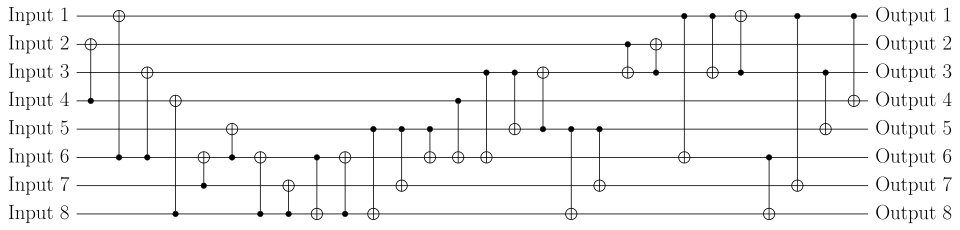

In [15]:
mat = circuit_to_matrix(input_circuit, size)
_, output_circuit = check_and_run(synthesise_circuit, mat, sec_size)

output_diagram_file_name = circuit_to_svg(output_circuit, size, diagram_dir, circuit_file_prefix + '_out')

print(f'output circuit length: {len(output_circuit)}')
display(SVG(rf'..\{diagram_dir}\{output_diagram_file_name}'))

### CONCLUSION

According to formula 3 from the paper, the length of the circuit for $n = 8$ should not exceed $144$. However, even for
the smallest circuit size $n = 8$ a visual inspection of the shortening by looking at the circuit diagrams makes little
sense.

Therefore in the notebook *runtime_performance.ipynb* a benchmark is performed measuring the length of the resulting
circuits in the range $8 \leq n \leq 100$.
